In [1]:
from auto_robot_design.motion_planning.dataset_generator import Dataset

dataset = Dataset("D:\\Files\\Working\\auto-robotics-design\\test_top_8")

In [2]:
import numpy as np
df = dataset.df
low_bnds = np.array([value[0] for value in dataset.graph_manager.mutation_ranges.values()])[np.newaxis,:]
up_bnds = np.array([value[1] for value in dataset.graph_manager.mutation_ranges.values()])[np.newaxis,:]
np.round(df.mean(0).values[:dataset.params_size],4), np.round(df.std(0).values[:dataset.params_size],4)

(array([-0.2   , -0.029 , -0.293 , -0.014 , -0.1349, -0.0067,  0.1496,
        -0.0851,  0.1399, -0.06  , -0.    , -0.025 , -0.05  ]),
 array([0.    , 0.    , 0.0255, 0.1655, 0.4138, 0.1618, 0.3675, 0.0531,
        0.049 , 0.0327, 0.0817, 0.0612, 0.0817]))

In [3]:
df.values[:,:dataset.params_size].max(0), df.values[:,:dataset.params_size].min(0)

(array([-0.2  , -0.029, -0.2  ,  0.2  ,  0.4  ,  0.2  ,  0.6  , -0.02 ,
         0.2  , -0.02 ,  0.1  ,  0.05 ,  0.05 ]),
 array([-0.2  , -0.029, -0.3  , -0.2  , -0.6  , -0.2  , -0.3  , -0.15 ,
         0.08 , -0.1  , -0.1  , -0.1  , -0.15 ]))

<BarContainer object of 2788 artists>

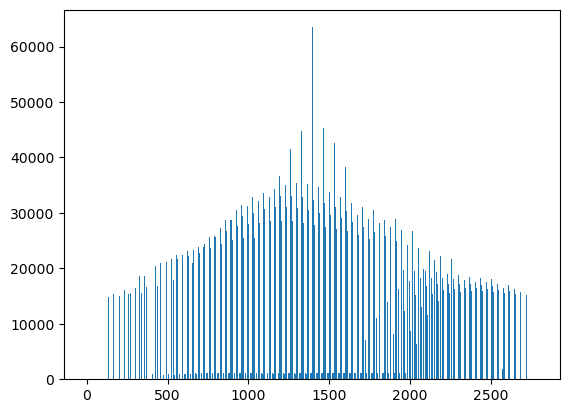

In [4]:
import matplotlib.pyplot as plt
dense_ws_point = np.sum(df.values[:,dataset.params_size:dataset.params_size+dataset.ws_grid_size],axis=0)
plt.bar(range(dataset.ws_grid_size), dense_ws_point)

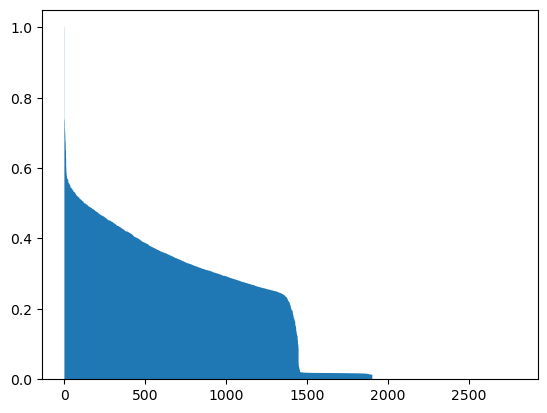

In [5]:
from matplotlib.patches import StepPatch
sorted_dense_points = sorted(dense_ws_point/df.shape[0], reverse=True)
plt.stairs(sorted_dense_points,range(dataset.ws_grid_size+1), fill=True)

In [6]:
upd_df = df.assign(total_ws=lambda x: np.sum(x.values[:,dataset.params_size:dataset.params_size+dataset.ws_grid_size],axis=1))
sorted_df = upd_df.sort_values("total_ws", ascending=False)
best_index_ws_sample = sorted_df.head(1).index[0]
best_index_ws_sample

60123

In [9]:
from auto_robot_design.description.builder import ParametrizedBuilder, URDFLinkCreater3DConstraints, jps_graph2pinocchio_robot_3d_constraints, MIT_CHEETAH_PARAMS_DICT
thickness = MIT_CHEETAH_PARAMS_DICT["thickness"]
actuator = MIT_CHEETAH_PARAMS_DICT["actuator"]
density = MIT_CHEETAH_PARAMS_DICT["density"]
body_density = MIT_CHEETAH_PARAMS_DICT["body_density"]


builder = ParametrizedBuilder(URDFLinkCreater3DConstraints,
                              density={"default": density, "G": body_density},
                              thickness={"default": thickness, "EE": 0.033},
                              actuator={"default": actuator},
                              size_ground=np.array(
                                  MIT_CHEETAH_PARAMS_DICT["size_ground"]),
                              offset_ground=MIT_CHEETAH_PARAMS_DICT["offset_ground_rl"]
                              )

dataset.builder = builder

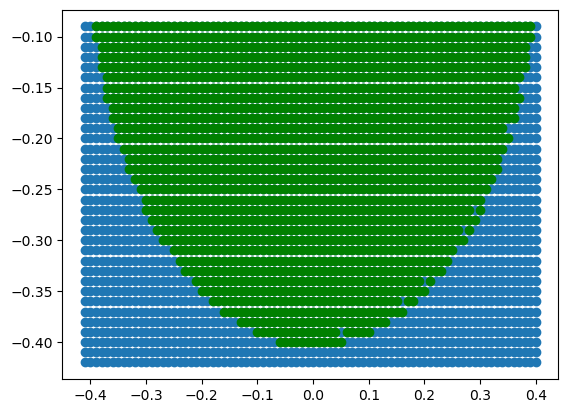

In [10]:
ws = dataset.get_workspace_by_indexes([best_index_ws_sample])[0]
reachable_pts = ws.reachable_points
pts = ws.points

plt.plot(reachable_pts[:,0],reachable_pts[:,1], "og")
plt.scatter(pts[:,0],pts[:,1])

In [14]:
from auto_robot_design.utils.meshcat_vizualizer.vizualizer import MeshcatVisualizer

viz = MeshcatVisualizer(model=ws.robot.model, collision_model=ws.robot.visual_model, visual_model=ws.robot.visual_model)
# viz.viewer = meshcat.Visualizer().open()
viz.viewer.jupyter_cell()
viz.viewer["/Background"].set_property("visible", False)
viz.viewer["/Grid"].set_property("visible", False)
viz.viewer["/Axes"].set_property("visible", False)
viz.viewer["/Cameras/default/rotated/<object>"].set_property("position", [0,0,0.5])
viz.clean()
viz.loadViewerModel()

viz.display(np.zeros(ws.robot.model.nq))

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


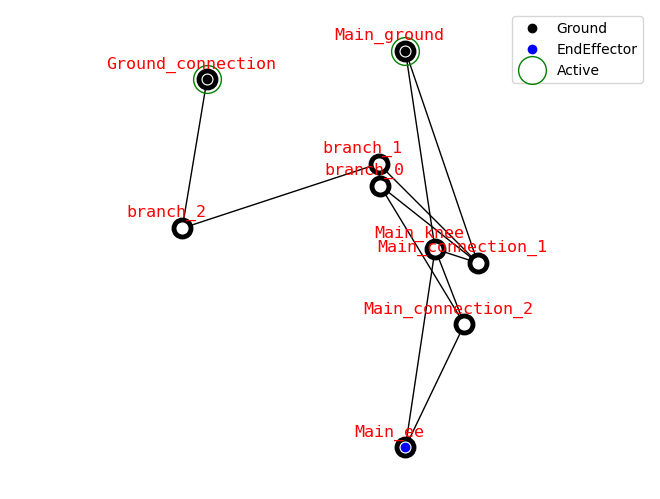

In [18]:
from auto_robot_design.description.utils import draw_joint_point
graph = dataset.get_graphs_by_indexes([best_index_ws_sample])[0]

draw_joint_point(graph)

In [34]:

from auto_robot_design.user_interface.check_in_ellips import (
    Ellipse,
    check_points_in_ellips
)
center_ellps = np.array([0.05,-0.21])
ellipse = Ellipse(center_ellps, 0, np.array([0.1, 0.04]))
points_on_ellps = ellipse.get_points(0.1).T

reach_ws_points = ws.points
mask_ws_n_ellps = check_points_in_ellips(reach_ws_points, ellipse, 0.1)

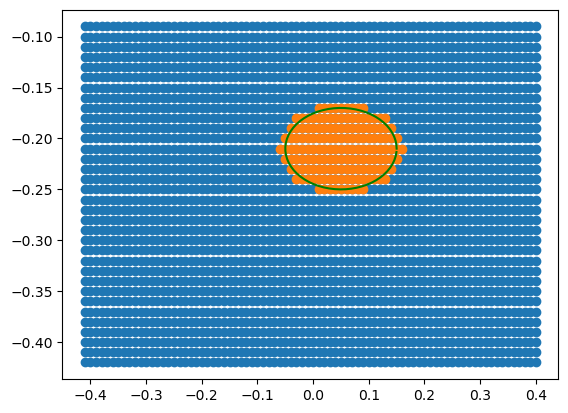

In [26]:
plt.plot(points_on_ellps[:,0], points_on_ellps[:,1], "g")
plt.scatter(pts[:,0],pts[:,1])
plt.scatter(reach_ws_points[mask_ws_n_ellps,:][:,0],reach_ws_points[mask_ws_n_ellps,:][:,1])

In [30]:
design_indexes_include_ellps = dataset.get_all_design_indexes_cover_ellipse(ellipse)
design_indexes_include_ellps.size

802

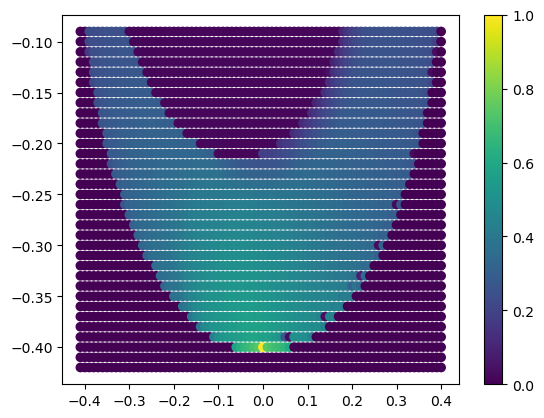

In [32]:
pts = dataset.workspace.points
plt.scatter(pts[:,0], pts[:,1],c=dense_ws_point/dataset.df.shape[0])
plt.colorbar()

In [35]:
from auto_robot_design.pinokla.default_traj import add_auxilary_points_to_trajectory


gm = dataset.graph_manager
traj = np.array(add_auxilary_points_to_trajectory(([center_ellps[0]], [center_ellps[1]]))).T
ws.check_points_in_ws(traj)


True

In [36]:
from auto_robot_design.motion_planning.trajectory_ik_manager import TrajectoryIKManager
from auto_robot_design.vizualization.meshcat_utils import create_meshcat_vizualizer
fixed_robot = ws.robot
traj_6d = fixed_robot.motion_space.get_6d_traj(traj)
ik_manager = TrajectoryIKManager()
ik_manager.register_model(fixed_robot.model, fixed_robot.constraint_models)
ik_manager.set_solver("Closed_Loop_PI")
poses, q_fixed, constraint_errors,reach_array = ik_manager.follow_trajectory(traj_6d)

In [37]:
upd_df["acc_cap"] = np.zeros(upd_df.shape[0])
upd_df["heavy_lift"] = np.zeros(upd_df.shape[0])
upd_df["total_criteria"] = np.zeros(upd_df.shape[0])

In [38]:

from auto_robot_design.pinokla.calc_criterion import ActuatedMass, EffectiveInertiaCompute, MovmentSurface, NeutralPoseMass, ManipJacobian
from auto_robot_design.pinokla.criterion_agregator import CriteriaAggregator
from auto_robot_design.optimization.rewards.reward_base import  RewardManager
from auto_robot_design.optimization.rewards.jacobian_and_inertia_rewards import HeavyLiftingReward, MinAccelerationCapability

import time

from concurrent.futures import ProcessPoolExecutor

dict_trajectory_criteria = {
    "MASS": NeutralPoseMass(),
}
# criteria calculated for each point on the trajectory
dict_point_criteria = {
    "Effective_Inertia": EffectiveInertiaCompute(),
    "Actuated_Mass": ActuatedMass(),
    "Manip_Jacobian": ManipJacobian(MovmentSurface.XZ)
}
# special object that calculates the criteria for a robot and a trajectory
crag = CriteriaAggregator(dict_point_criteria, dict_trajectory_criteria)

# set the rewards and weights for the optimization task
acceleration_capability = MinAccelerationCapability(manipulability_key='Manip_Jacobian',
                                                    trajectory_key="traj_6d", error_key="error", actuated_mass_key="Actuated_Mass")

heavy_lifting = HeavyLiftingReward(
    manipulability_key='Manip_Jacobian', trajectory_key="traj_6d", error_key="error", mass_key="MASS")


reward_manager = RewardManager(crag=crag)
reward_manager.add_trajectory(traj_6d, 0)

reward_manager.add_reward(acceleration_capability, 0, 1)
reward_manager.add_reward(heavy_lifting, 0, 1)
total_time = 0

def cacl_criteria(id_design):
    start = time.perf_counter()
    des = upd_df.loc[id_design]
    jp_pos = des.values[:dataset.params_size].round(4)
    graph = gm.get_graph(jp_pos)
    fixed_robot, free_robot = jps_graph2pinocchio_robot_3d_constraints(
        graph, builder)
    reward_manager.precalculated_trajectories = None
    __, partial_rewards, vector_rewards = reward_manager.calculate_total(
        fixed_robot, free_robot, actuator)
    end = time.perf_counter()
    upd_df.at[id_design, "acc_cap"] = vector_rewards[0]
    upd_df.at[id_design, "heavy_lift"] = vector_rewards[1]
    upd_df.at[id_design, "total_criteria"] = np.sum(partial_rewards)
    single_time = end - start
    print(single_time)
    
    return id_design, partial_rewards


for id_design in upd_df.head(10).index:
    start = time.perf_counter()
    des = upd_df.loc[id_design]
    jp_pos = des.values[:dataset.params_size].round(4)
    graph = gm.get_graph(jp_pos)
    fixed_robot, free_robot = jps_graph2pinocchio_robot_3d_constraints(
        graph, builder)
    reward_manager.precalculated_trajectories = None
    __, partial_rewards, vector_rewards = reward_manager.calculate_total(
        fixed_robot, free_robot, actuator)
    end = time.perf_counter()
    upd_df.at[id_design, "acc_cap"] = vector_rewards[0]
    upd_df.at[id_design, "heavy_lift"] = vector_rewards[1]
    upd_df.at[id_design, "total_criteria"] = np.sum(partial_rewards)
    single_time = end - start
    total_time += single_time
    print("time: ",np.round(single_time, 4))
print(total_time)

time:  0.2109
time:  0.1911
time:  0.1356
time:  0.1875
time:  0.2046
time:  0.1398
time:  0.1531
time:  0.1474
time:  0.1431
time:  0.1797
1.6927913000006356


In [41]:
upd_df.head(10)

,jp_0,jp_1,jp_2,jp_3,jp_4,jp_5,jp_6,jp_7,jp_8,jp_9,...,ws_2782,ws_2783,ws_2784,ws_2785,ws_2786,ws_2787,total_ws,acc_cap,heavy_lift,total_criteria
0,-0.2,-0.029,-0.3,-0.2,-0.6,-0.2,-0.3,-0.15,0.08,-0.1,...,0.0,0.0,0.0,0.0,0.0,0.0,1263.0,0.013718,0.057522,0.071240
1,-0.2,-0.029,-0.3,-0.2,-0.6,-0.2,-0.3,-0.15,0.08,-0.1,...,0.0,0.0,0.0,0.0,0.0,0.0,831.0,0.229824,4.408331,4.638154
2,-0.2,-0.029,-0.3,-0.2,-0.6,-0.2,-0.3,-0.15,0.08,-0.1,...,0.0,0.0,0.0,0.0,0.0,0.0,579.0,0.339896,4.993257,5.333153
3,-0.2,-0.029,-0.3,-0.2,-0.6,-0.2,-0.3,-0.15,0.08,-0.1,...,0.0,0.0,0.0,0.0,0.0,0.0,1061.0,0.004648,0.019000,0.023647
4,-0.2,-0.029,-0.3,-0.2,-0.6,-0.2,-0.3,-0.15,0.08,-0.1,...,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.361147,5.298056,5.659203
5,-0.2,-0.029,-0.3,-0.2,-0.6,-0.2,-0.3,-0.15,0.08,-0.1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.010867,6.087608,6.098474
6,-0.2,-0.029,-0.3,-0.2,-0.6,-0.2,-0.3,-0.15,0.08,-0.1,...,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.306798,5.579169,5.885966
7,-0.2,-0.029,-0.3,-0.2,-0.6,-0.2,-0.3,-0.15,0.08,-0.1,...,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.229207,6.935894,7.165101
8,-0.2,-0.029,-0.3,-0.2,-0.6,-0.2,-0.3,-0.15,0.08,-0.1,...,0.0,0.0,0.0,0.0,0.0,0.0,561.0,0.275883,8.113315,8.389198
9,-0.2,-0.029,-0.3,-0.2,-0.6,-0.2,-0.3,-0.15,0.08,-0.1,...,0.0,0.0,0.0,0.0,0.0,0.0,1343.0,0.206021,1.000456,1.206477
